<a href="https://colab.research.google.com/github/Rbca0/Data-Science/blob/main/UnitCinco/RebeVanbU5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### wikiHow to Measure your brain's weight

People have heads, but it's hard to figure out how much their brains weigh while they're alive. However, you can measure the ssize of a persons head!If you want to figure out their brain's weight, you should try estimating 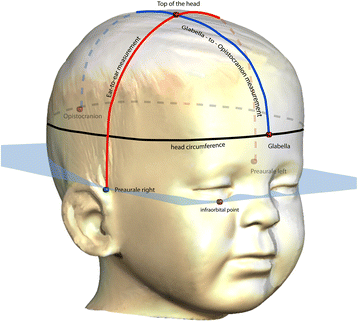

### Step 1
Get some data. While it may seem more difficult than just putting your brain on a scale, having a dataset to analyze will help you figure out how much your brain weighs. It's useful to be alive when wanting to know something. 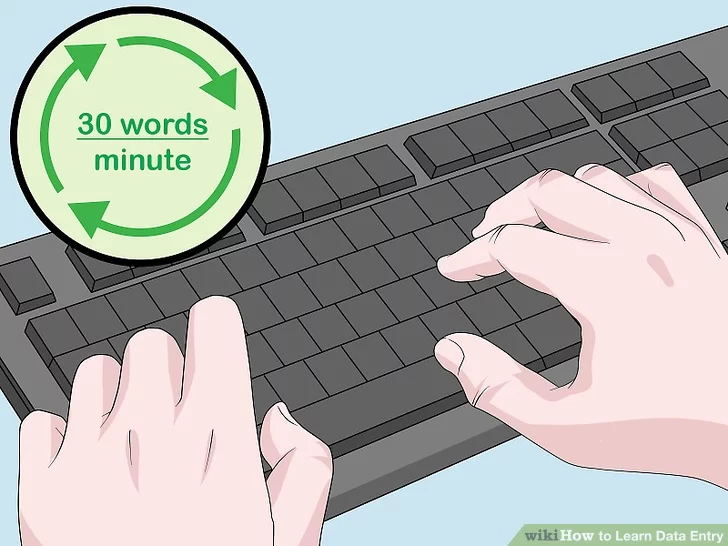

data https://users.stat.ufl.edu/~winner/data/brainhead.dat

### Step 2:
Import the below things as strings of 2 letter acronyms.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

In [3]:
#load the data into a pandas dataframe, and print it
url_head = 'https://raw.githubusercontent.com/Rbca0/Data-Science/refs/heads/main/brain%20-%20Sheet1.csv'
#I could have put the url string directly into pd.read_csv()
head = pd.read_csv(url_head)

In [ ]:
#the data
head

,head_size,brain_weight
0,4512,1530
1,3738,1297
2,4261,1335
3,3777,1282
4,4177,1590
...,...,...
232,3214,1110
233,3394,1215
234,3233,1104
235,3352,1170


Step 3:
Do data analysis with a generalized linear model. Making graphs and choosing large standard devations for your model's variables will help you understand the data.

<Axes: xlabel='head_size', ylabel='brain_weight'>

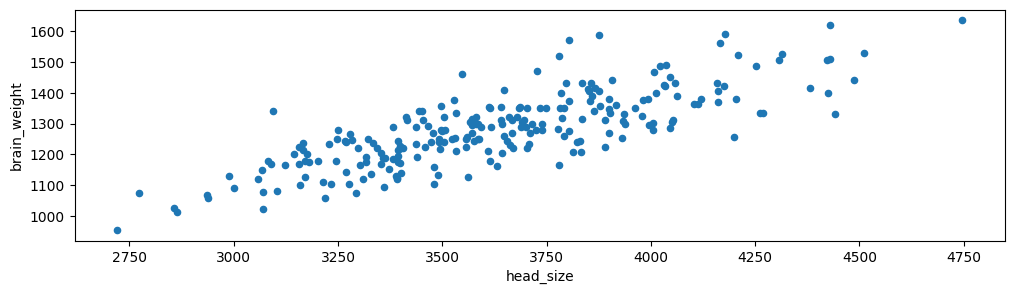

In [ ]:
#scatter plot of head size (cm^3) vs brain weight (grams)
head.plot(x="head_size", y="brain_weight", figsize=(12, 3), kind="scatter")

Use your computer to graph the data
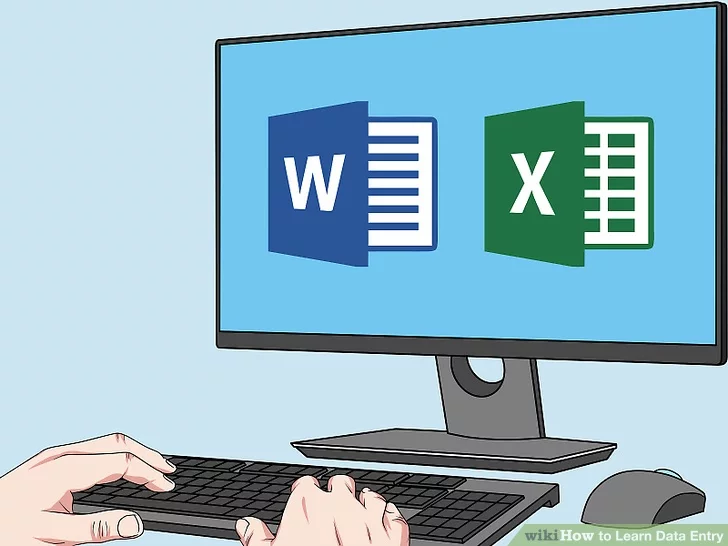

Wow, this looks pretty linear. I think head size causes brain weight.

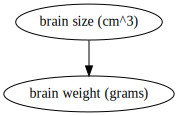

In [ ]:
dag_b = gv.Digraph(comment='bikes_dag') #b for bikes

dag_b.node('R', 'brain weight (grams)')
dag_b.node('T','brain size (cm^3)')

dag_b.edges(['TR', ])

dag_b

In [ ]:
##GLM with no math function added
with pm.Model() as model_hw:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * head.head_size)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 5)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=head.brain_weight)

    #inference data object
    idata_hw = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_hw, model=model_hw,  extend_inferencedata=True)

<Axes: xlabel='y_pred'>

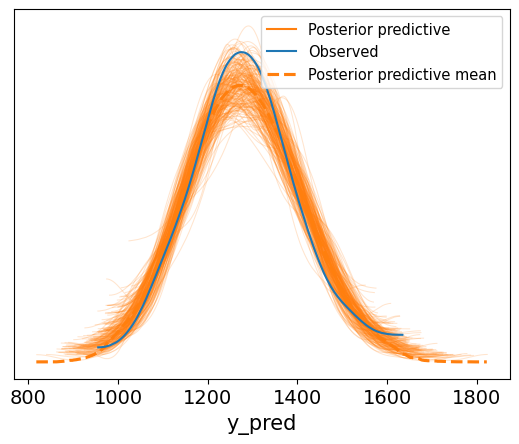

In [ ]:
az.plot_ppc(idata_hw, num_pp_samples=200, colors=["C1", "C0", "C1"])

### Step 4:
### Do posterior predictive checks
This posterior predictive check went well!! The mean line is slightly under the data line at the peak of the graph, but generally the posterior predictive lines are close to the data line.

Text(0, 0.5, 'brain weight')

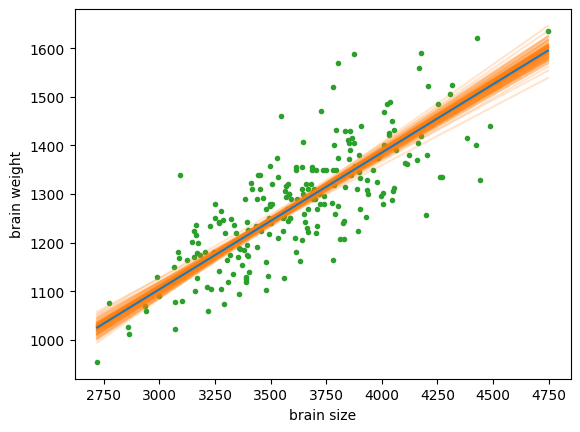

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_hw, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(head.head_size.min(), head.head_size.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(head.head_size, head.brain_weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("brain size")
ax.set_ylabel("brain weight")

Text(0, 0.5, 'brain weight')

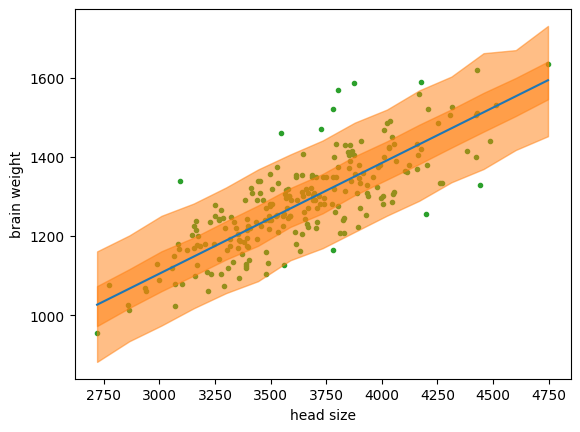

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_hw.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
brain_size = np.random.normal(head.head_size.values, 0.01)
idx = np.argsort(brain_size)
x = np.linspace(brain_size.min(), brain_size.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_hw.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(brain_size[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(head.head_size, head.brain_weight, "C2.", zorder=-3)
ax.plot(head.head_size[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("head size")
ax.set_ylabel("brain weight")
##gmemein helped me spelell

This is also good! The variable variance doesn't seem to be that necessary, though.

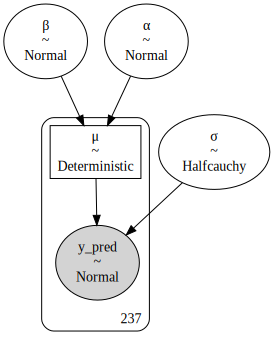

In [ ]:
#visualization of distributional relations in the linear model structure
pm.model_to_graphviz(model_hw)

In [ ]:
# posterior predictive check
pm.sample_posterior_predictive(idata_hw, model=model_hw,  extend_inferencedata=True)

Hmmm . . . should I try making a nonlinear linear model?

<Axes: ylabel='brain_weight'>

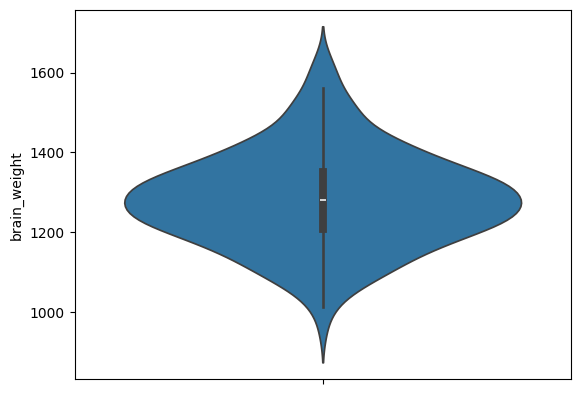

In [ ]:

sns.violinplot(head.brain_weight)

### Step 5: Try exponentiating your model
While a linear GLM is simple and easy to understand, you may want to add nuance by exponentiating or sqare rooting your linear curve. Do this like the code below!

In [ ]:
#ANSWER5 cont.

with pm.Model() as model_hwb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=1, sigma=5)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * head.head_size))

    #prior for the likelihood's standard deviation
    b = pm.HalfNormal("b", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=b, observed=head.brain_weight)

    idata_hwb = pm.sample(target_accept=.99)

In [ ]:
#ANSWER5 cont.

#creates our posterior predictive distribution
pm.sample_posterior_predictive(idata_hwb, model = model_hwb, extend_inferencedata=True)

<Axes: xlabel='y_pred'>

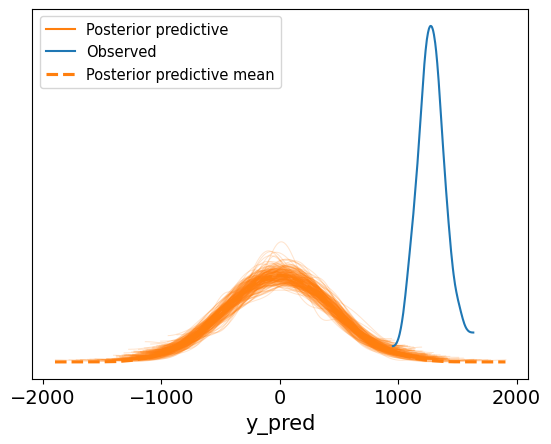

In [38]:
#ANSWER5 cont.

# posterior predictive check
az.plot_ppc(idata_hwb, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'brain weight')

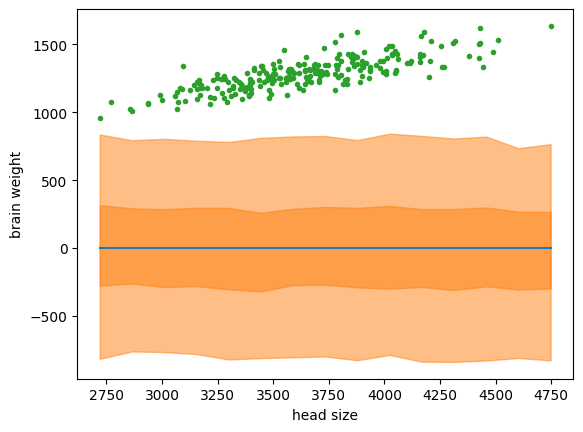

In [39]:
#ANSWER5 cont.

mean_line = idata_hwb.posterior["μ"].mean(("chain", "draw"))
head_weight = np.random.normal(head.head_size.values, 0.01)
idx = np.argsort(head_weight)
x = np.linspace(head_weight.min(), head_weight.max(), 15)
y_pred_q = idata_hwb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(head_weight[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(head.head_size, head.brain_weight, "C2.", zorder=-3)
ax.plot(head.head_size[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("head size")
ax.set_ylabel("brain weight")

### Step 6:
### Analyze your final posterior predictive checks & conclude
Wow, it looks like our data is not eppontential. I think the linear model is the best.

### Step 7: Estimate your head size
Next, set up a bucket inside a larger container, like a big storage bin or fish tank. Fill the water in the bucket all the water up to the top,
Add water until the water in the container is almost spilling over, and dunk your head in slowly.
Then, remove your head. The excess water that spills out of your container is the volume of your head!
Measure the volume of this water by pouring it into a graduated cylinder.
Repeat three times and take the average (https://www.wikihow.com/Find-Mean,-Median,-and-Mode) volume of your head. 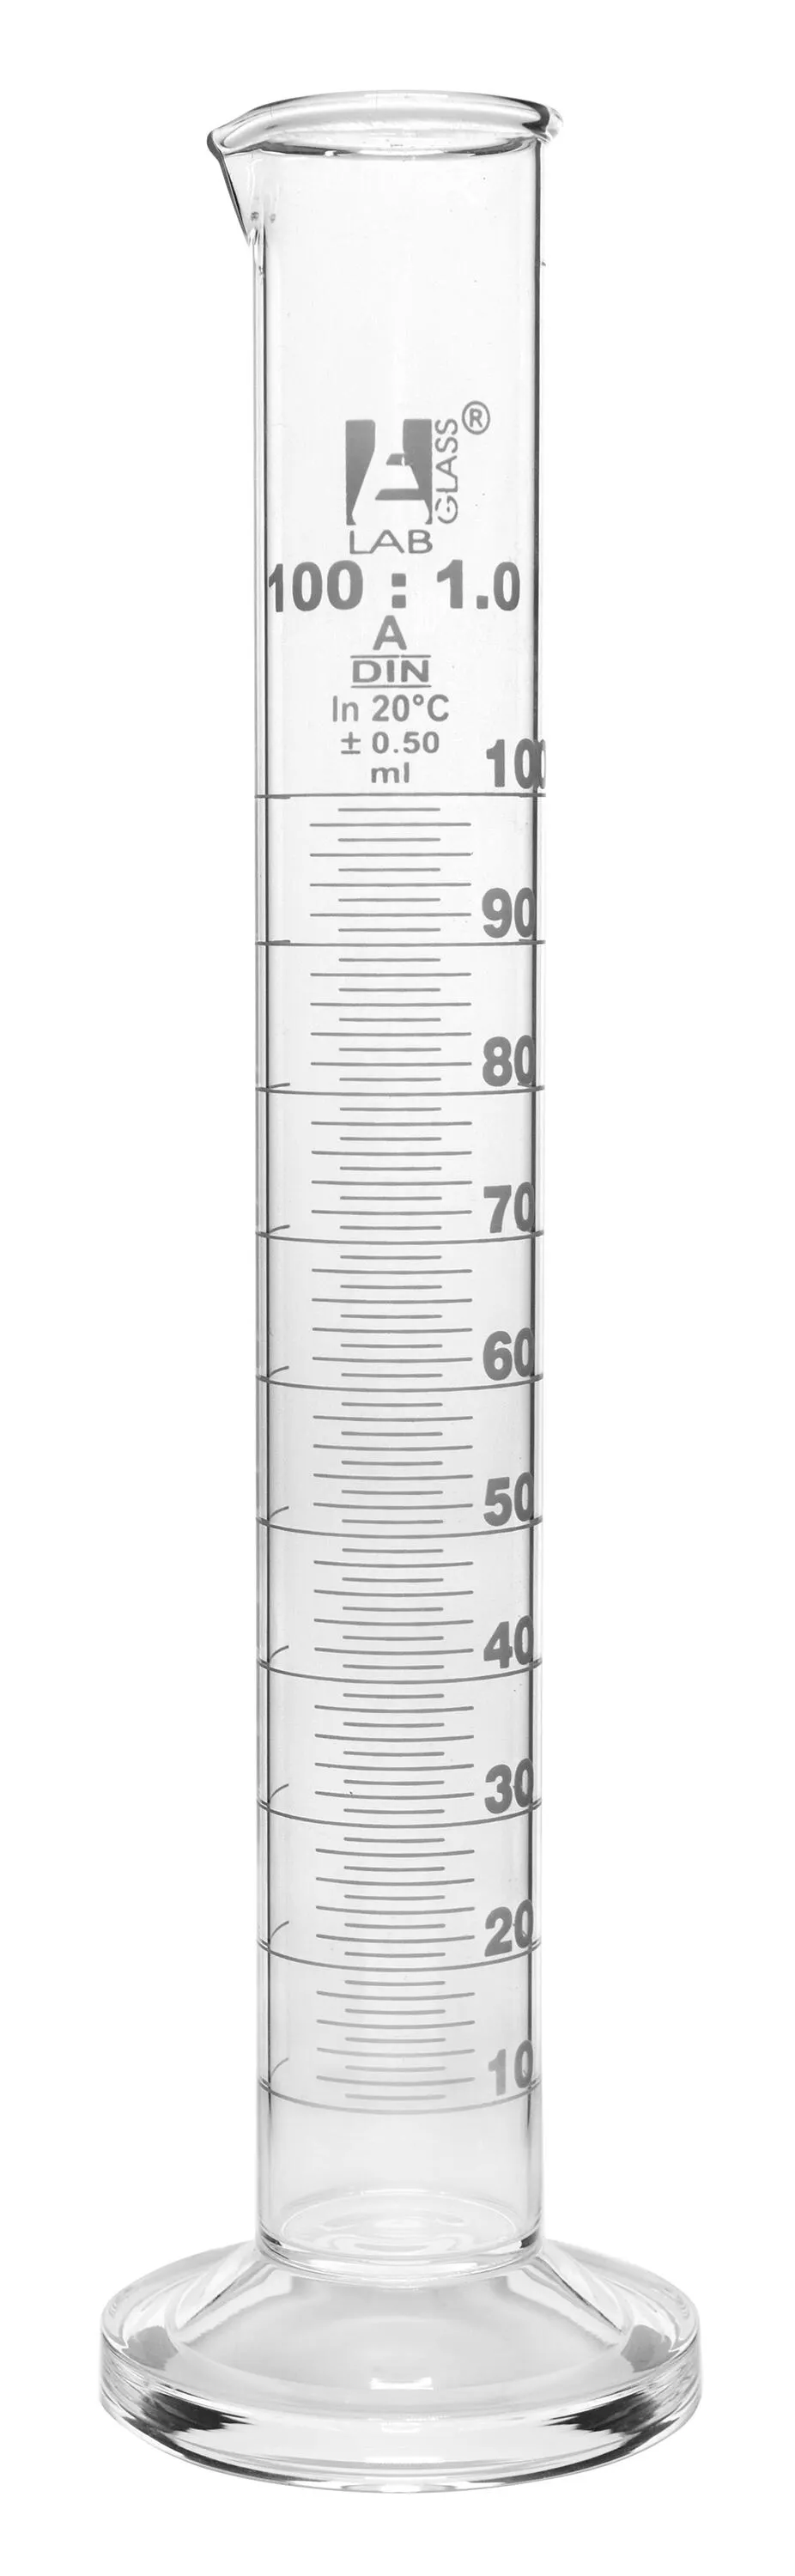

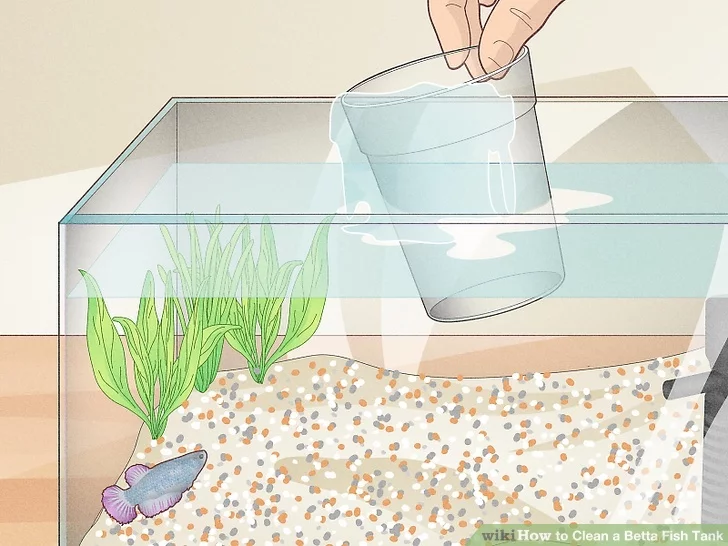

### Step 8:Estimate your brain weight
Using your newfound head volume measurement, map it using your created trend line to estimate the wweight of your brain!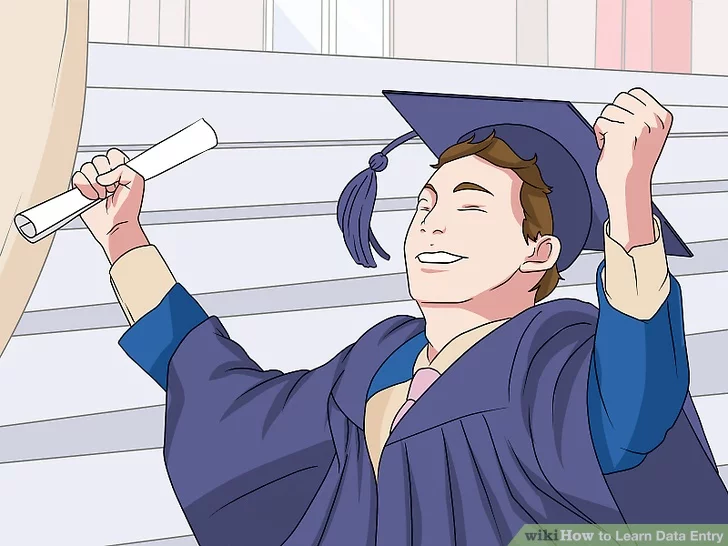